In [1]:
import geopandas as gpd
import shapely
from geovoronoi import voronoi_regions_from_coords
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from sklearn.cluster import KMeans, DBSCAN
import random
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [3]:
def generate_random(number, polygon):
    '''
    from https://gis.stackexchange.com/questions/207731/generating-random-coordinates-in-multipolygon-in-python
    modified to output a geopandas df
    '''
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points.append(pnt)
            
    points_df = gpd.GeoDataFrame(pd.DataFrame(range(len(points)),columns=['pt_id']),
                            crs="EPSG:4326",
                            geometry=points)
    return points_df

def add_random_pts(address_points_for_cluster):
    '''
    '''
    random_extent = 0.0001
    new_point_list = []
    for point in address_points_for_cluster:
        minx = point[0]-random_extent
        maxx = point[0]+random_extent
        miny = point[1]-random_extent
        maxy = point[1]+random_extent
        new_point_list.append((random.uniform(minx, maxx), random.uniform(miny, maxy)))
    address_points_plus_rand = np.vstack((address_points_for_cluster,np.array(new_point_list)))
    return address_points_plus_rand

def split_poly_into_equal_parts(poly, num_parts):
    '''
    '''
    points_df = generate_random(2500, poly)
    km = KMeans(n_clusters=num_parts)
    
    points_df.loc[:,'lat'] = points_df.loc[:,'geometry'].apply(lambda x: x.y)
    points_df.loc[:,'lon'] = points_df.loc[:,'geometry'].apply(lambda x: x.x)
    points_for_cluster = points_df.copy()
    points_for_cluster.drop(labels=['geometry','pt_id'],axis=1,inplace=True)
    
    kmcls = km.fit(points_for_cluster.values)
    
    points_w_cl = points_df.assign(cluster=kmcls.labels_)
    centers = kmcls.cluster_centers_
    
    centers_gseries = gpd.GeoSeries(map(Point, zip(centers[:,1], centers[:,0])))
    
    centroid_coords = np.array([coords for coords in (zip(centers[:,1], centers[:,0]))])
    
    poly_shapes, pts, poly_to_pt_assignments  = voronoi_regions_from_coords(centroid_coords, poly)
    
    poly_shapes_df = gpd.GeoDataFrame(pd.DataFrame(poly_to_pt_assignments,columns=['group']),
                            crs="EPSG:4326",
                            geometry=poly_shapes)
    
    return poly_shapes_df

# Load the DC `squares` (I think of them as city blocks)

In [4]:
squares = gpd.read_file("gis_data/Square_Boundaries-shp/")

In [5]:
squares.head(3)

,OBJECTID,GIS_ID,CREATION_D,RECORDATIO,NARRATIVE,EXPIRATION,STATUS,SQUARE,SUFFIX,COMPUTED_A,...,SQUAREPLYI,FIT_ROTATI,FIT_ROTA_1,FIT_ROTA_2,SW_CORNER_,SW_CORNE_1,KILL_DT,SHAPEAREA,SHAPELEN,geometry
0,2717682,1174138.0,2006-09-09,1970-01-01,DELIVERY 12,1970-01-01,1,6239,S,401844,...,None,NaN,NaN,NaN,NaN,NaN,1970-01-01,37332.666173,1167.603867,"POLYGON ((-77.00694 38.82504, -77.00632 38.824..."
1,2717683,1177508.0,2006-09-09,1970-01-01,DELIVERY 6,1970-01-01,1,1303,None,105420,...,None,NaN,NaN,NaN,NaN,NaN,1970-01-01,9793.879221,438.912894,"POLYGON ((-77.06988 38.91432, -77.06987 38.914..."
2,2717684,1173503.0,2006-09-09,1970-01-01,DELIVERY 12,1970-01-01,1,5521,None,157309,...,None,NaN,NaN,NaN,NaN,NaN,1970-01-01,14614.509037,550.917664,"POLYGON ((-76.94705 38.86496, -76.94705 38.864..."


# load `address_pts`

In [6]:
addresses = gpd.read_file("gis_data/Address_Points-shp/")

In [7]:
addresses.shape

(148157, 59)

In [8]:
addresses.head(3)

,OBJECTID_1,OBJECTID,SITE_ADDRE,ADDRESS_ID,ROADWAYSEG,STATUS,SSL,TYPE_,ENTRANCETY,ADDRNUM,...,ACTIVE_RES,RES_TYPE,ACTIVE_R_1,WARD_2002,WARD_2012,ANC_2002,ANC_2012,SMD_2002,SMD_2012,geometry
0,832017,1087.0,27746,27746,11690.0,ACTIVE,0814 0018,ADDRESS,OFFICIAL,402.0,...,0.0,RESIDENTIAL,1.0,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C07,SMD 6C03,POINT (-77.00035 38.89220)
1,832018,3265.0,50808,50808,3073.0,ACTIVE,0838 0027,ADDRESS,OFFICIAL,219.0,...,0.0,RESIDENTIAL,1.0,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C07,SMD 6C03,POINT (-76.99925 38.89265)
2,832019,3266.0,51065,51065,3073.0,ACTIVE,0814 0818,ADDRESS,OFFICIAL,216.0,...,1.0,RESIDENTIAL,2.0,Ward 6,Ward 6,ANC 6C,ANC 6C,SMD 6C07,SMD 6C03,POINT (-76.99977 38.89256)


In [9]:
addresses.iloc[0]

OBJECTID_1                                              832017
OBJECTID                                                  1087
SITE_ADDRE                                               27746
ADDRESS_ID                                               27746
ROADWAYSEG                                               11690
STATUS                                                  ACTIVE
SSL                                               0814    0018
TYPE_                                                  ADDRESS
ENTRANCETY                                            OFFICIAL
ADDRNUM                                                    402
ADDRNUMSUF                                                None
STNAME                                            CONSTITUTION
STREET_TYP                                              AVENUE
QUADRANT                                                    NE
CITY                                                WASHINGTON
STATE                                                  

In [10]:
addresses.loc[:,'RES_TYPE'].unique()

array(['RESIDENTIAL', 'NON RESIDENTIAL', 'MIXED USE'], dtype=object)

In [11]:
res_addresses = addresses[addresses.loc[:,'RES_TYPE']=='RESIDENTIAL'].copy()

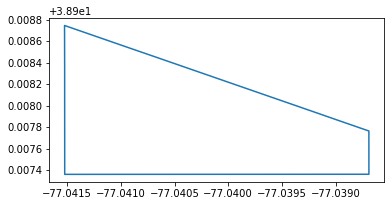

In [12]:
square_id = '0158'
#0196 - maybe break up multipolygons before?
one_square = squares[squares.loc[:,'SQUARE']==square_id].copy()
one_square.boundary.plot()

In [13]:
for poly in one_square.iloc[0].geometry:
    print("woow")

TypeError: 'Polygon' object is not iterable

In [ ]:
len(one_square)

In [ ]:
address_pts[address_pts.within(one_square_shape)]

In [131]:
address_pts = addresses[addresses.loc[:,'SQUARE']==square_id].copy()
shape_part = 1
if len(one_square) > 1:
    for index, row in enumerate(one_square.iterrows()):
        print(f"square_id {row['SQUARE']}")
        one_square_shape = row['geometry']
        address_within = address_pts[address_pts.within(one_square_shape)].copy()
        print(f"index {index}")
        
        

ValueError: not enough values to unpack (expected 3, got 2)

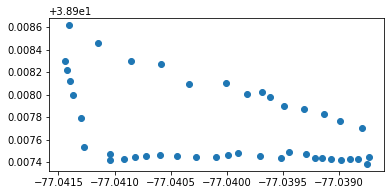

In [15]:
address_pts = addresses[addresses.loc[:,'SQUARE']==square_id].copy()
address_pts.plot()

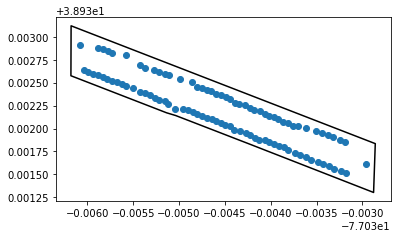

In [93]:
fig, ax = plt.subplots()
one_square.boundary.plot(ax=ax, edgecolor='black')
address_pts.plot(ax=ax)

In [16]:
for_cluster = pd.get_dummies(address_pts[['LATITUDE', 'LONGITUDE','STNAME']], prefix=['STNAME'])
for_cluster.iloc[:,2:] = for_cluster.iloc[:,2:].multiply(1,axis=1)
address_points_for_cluster = for_cluster.values

km_silhouette = {}
max_cluster = min(10,len(address_points_for_cluster))
print(f"max_num_clusters = {max_cluster-1}")
for i in range(2,max_cluster):
    km = KMeans(n_clusters=i, random_state=0).fit(address_points_for_cluster)
    preds = km.predict(address_points_for_cluster)
    
    silhouette = silhouette_score(address_points_for_cluster,preds)
    km_silhouette[silhouette] = i
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    print("-"*100)

max_num_clusters = 9
Silhouette score for number of cluster(s) 2: 0.7816014648586691
----------------------------------------------------------------------------------------------------
Silhouette score for number of cluster(s) 3: 0.9528866193821421
----------------------------------------------------------------------------------------------------
Silhouette score for number of cluster(s) 4: 0.9761258104897041
----------------------------------------------------------------------------------------------------
Silhouette score for number of cluster(s) 5: 0.7776642311478656
----------------------------------------------------------------------------------------------------
Silhouette score for number of cluster(s) 6: 0.6556203754956883
----------------------------------------------------------------------------------------------------
Silhouette score for number of cluster(s) 7: 0.6337467458687227
------------------------------------------------------------------------------------------

# just make at least 4 clusters

In [17]:
best_num_clusters = max(4,km_silhouette[max(km_silhouette.keys())])
km = KMeans(n_clusters=best_num_clusters, random_state=0).fit(address_points_for_cluster)
centers = km.cluster_centers_
centroid_coords = np.array([coords for coords in (zip(centers[:,1], centers[:,0]))])
centers_gseries = gpd.GeoSeries(map(Point, zip(centers[:,1], centers[:,0])))
address_pts_w_cluster = address_pts.assign(cluster=km.labels_)

In [18]:
centroid_coords

array([[-77.03993994,  38.90805736],
       [-77.03991097,  38.90743983],
       [-77.04138601,  38.90807954],
       [-77.03873358,  38.90743831]])

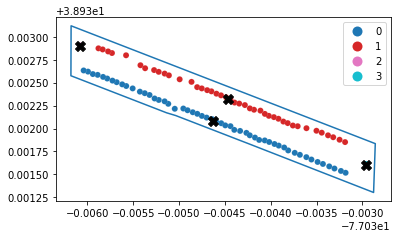

In [107]:
fig, ax = plt.subplots()
one_square.boundary.plot(ax=ax)
address_pts_w_cluster.plot(column='cluster', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)
centers_gseries.plot(ax=ax, alpha=1, marker='X', color='black', markersize=100, zorder=3)

In [99]:
centroid_filtered = centers_gseries[centers_gseries.apply(lambda x: one_square.unary_union.contains(x))].copy()
centroid_coords_filtered = np.array([coords for coords in (zip(centroid_filtered.apply(lambda x: x.x), 
                                    centroid_filtered.apply(lambda x: x.y)))])

In [100]:
poly_shapes, pts, poly_to_pt_assignments  = voronoi_regions_from_coords(centroid_coords_filtered, one_square.unary_union)

poly_shapes_df = gpd.GeoDataFrame(pd.DataFrame(poly_to_pt_assignments,columns=['group']),
                        crs="EPSG:4326",
                        geometry=poly_shapes)

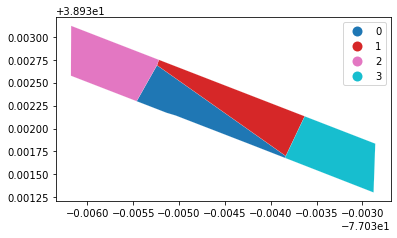

In [101]:
fig, ax = plt.subplots()
poly_shapes_df.plot(column='group', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)

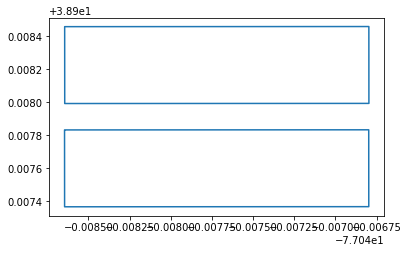

In [180]:
square_id = '0069'
one_square = squares[squares.loc[:,'SQUARE']==square_id].copy()
one_square_shape = one_square.geometry.values[0]
one_square.boundary.plot()

In [181]:
one_square.explode()

OBJECTID     GIS_ID  CREATION_D  RECORDATIO NARRATIVE  EXPIRATION  \
406 0   2718039  1176519.0  2006-09-09  1970-01-01   PHASE 1  1970-01-01   
    1   2718039  1176519.0  2006-09-09  1970-01-01   PHASE 1  1970-01-01   

       STATUS SQUARE SUFFIX  COMPUTED_A  ... SQUAREPLYI FIT_ROTATI  \
406 0       1   0069   None      178724  ...       None        NaN   
    1       1   0069   None      178724  ...       None        NaN   

       FIT_ROTA_1  FIT_ROTA_2  SW_CORNER_  SW_CORNE_1     KILL_DT  \
406 0         NaN         NaN         NaN         NaN  1970-01-01   
    1         NaN         NaN         NaN         NaN  1970-01-01   

          SHAPEAREA    SHAPELEN  \
406 0  16604.099946  848.149164   
    1  16604.099946  848.149164   

                                                geometry  
406 0  POLYGON ((-77.04865 38.90750, -77.04865 38.907...  
    1  POLYGON ((-77.04864 38.90802, -77.04864 38.908...  

[2 rows x 21 columns]

In [161]:
for idx, poly in enumerate(one_square_shape):
    if idx == 0:
        test_poly = poly
    print(idx)

0
1


In [163]:
for index, row in one_square.iterrows():
    if row.geometry.type == 'MultiPolygon':
        print("yayy")

yayy


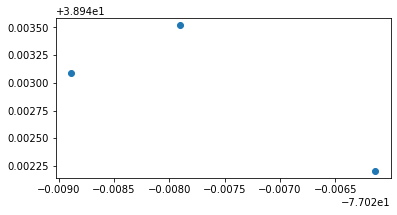

In [24]:
address_pts = addresses[addresses.loc[:,'SQUARE']==square_id].copy()
address_pts.plot()

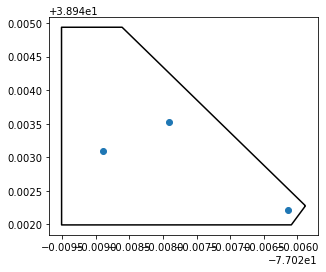

In [25]:
fig, ax = plt.subplots()
one_square.boundary.plot(ax=ax, edgecolor='black')
address_pts.plot(ax=ax)

In [219]:
def prep_addresses_for_cluster(address_pts, one_square_shape):
    '''
    '''
    address_within = address_pts[address_pts.within(one_square_shape)].copy()
    for_cluster = pd.get_dummies(address_within[['LATITUDE', 'LONGITUDE','STNAME']], prefix=['STNAME'])
    for_cluster.iloc[:,2:] = for_cluster.iloc[:,2:].multiply(500,axis=1)
    address_points_for_cluster = for_cluster.values
    return address_points_for_cluster
    
def find_address_clusters(address_points_for_cluster):
    '''
    '''
    km_silhouette = {}
    max_cluster = min(10,len(address_points_for_cluster))
#     print(f"max_num_clusters = {max_cluster-1}")
    for i in range(2,max_cluster):
        km = KMeans(n_clusters=i, random_state=0).fit(address_points_for_cluster)
        preds = km.predict(address_points_for_cluster)

        silhouette = silhouette_score(address_points_for_cluster,preds)
        km_silhouette[silhouette] = i
#         print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
#         print("-"*100)
    best_num_clusters = max(4,km_silhouette[max(km_silhouette.keys())])
    km = KMeans(n_clusters=best_num_clusters, random_state=0).fit(address_points_for_cluster)
    centers = km.cluster_centers_
    centroid_coords = np.array([coords for coords in (zip(centers[:,1], centers[:,0]))])
    centers_gseries = gpd.GeoSeries(map(Point, zip(centers[:,1], centers[:,0])))
#     address_pts_w_cluster = address_pts.assign(cluster=km.labels_)
    
    return centroid_coords

In [223]:
def split_poly_into_parts(square_id, squares, addresses):
    '''
    '''
    select_square = squares[squares.loc[:,'SQUARE']==square_id].copy()
    if (select_square.geometry.type=='MultiPolygon').any():
        select_square = select_square.explode()
    address_pts = addresses[addresses.loc[:,'SQUARE']==square_id].copy()
    square_part = 1
    for index, one_square in select_square.iterrows():
        one_square_shape = one_square['geometry']
        address_points_for_cluster = prep_addresses_for_cluster(address_pts, one_square_shape)
        if len(address_points_for_cluster)<4:
            split_type = "equal_area"
            poly_shapes_df = split_poly_into_equal_parts(one_square_shape, 4)
        else:
            split_type = "address_cluster"
            centroid_coords = find_address_clusters(address_points_for_cluster)

            poly_shapes, pts, poly_to_pt_assignments  = voronoi_regions_from_coords(centroid_coords, one_square_shape)

            poly_shapes_df = gpd.GeoDataFrame(pd.DataFrame(poly_to_pt_assignments,columns=['group']),
                                    crs="EPSG:4326",
                                    geometry=poly_shapes)
                
            poly_shapes_df.loc[:,'SQUARE'] = square_id
            poly_shapes_df.loc[:,'SQUARE_PART'] = square_part
            
        if square_part == 1:
            full_poly_shape_df = poly_shapes_df.copy()
        else:
            full_poly_shape_df = full_poly_shape_df.append(poly_shapes_df)
        square_part += 1
        
    return full_poly_shape_df

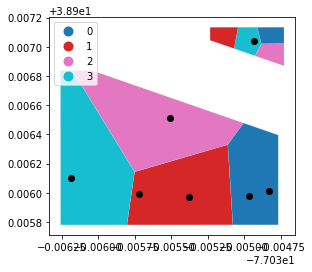

In [221]:
square_id = '0196'
poly_shapes_df = split_poly_into_parts(square_id, squares, addresses)
fig, ax = plt.subplots()
address_pts = address_pts = addresses[addresses.loc[:,'SQUARE']==square_id].copy()
poly_shapes_df.plot(column='group', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)
address_pts.plot(ax=ax, color='black')

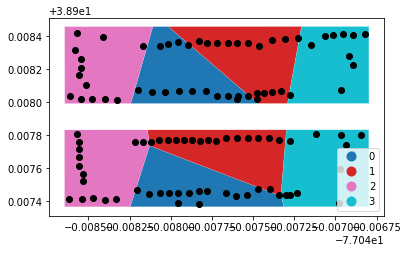

In [222]:
square_id = '0069'
poly_shapes_df = split_poly_into_parts(square_id, squares, addresses)
address_pts = address_pts = addresses[addresses.loc[:,'SQUARE']==square_id].copy()
fig, ax = plt.subplots()
poly_shapes_df.plot(column='group', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)
address_pts.plot(ax=ax, color='black')

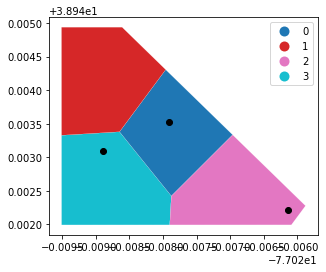

In [146]:
square_id = '2915'
poly_shapes_df = split_poly_into_parts(square_id, squares, addresses)
address_pts = address_pts = addresses[addresses.loc[:,'SQUARE']==square_id].copy()
fig, ax = plt.subplots()
poly_shapes_df.plot(column='group', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)
address_pts.plot(ax=ax, color='black')

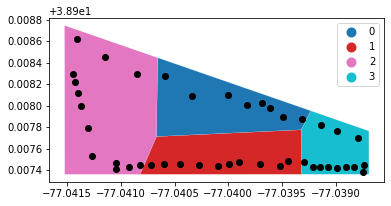

In [147]:
square_id = '0158'
poly_shapes_df = split_poly_into_parts(square_id, squares, addresses)
address_pts = address_pts = addresses[addresses.loc[:,'SQUARE']==square_id].copy()
fig, ax = plt.subplots()
poly_shapes_df.plot(column='group', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)
address_pts.plot(ax=ax, color='black')

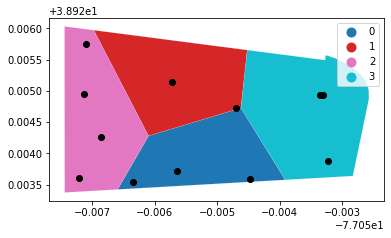

In [150]:
square_id = '2132'
poly_shapes_df = split_poly_into_parts(square_id, squares, addresses)
address_pts = address_pts = addresses[addresses.loc[:,'SQUARE']==square_id].copy()
fig, ax = plt.subplots()
poly_shapes_df.plot(column='group', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)
address_pts.plot(ax=ax, color='black')

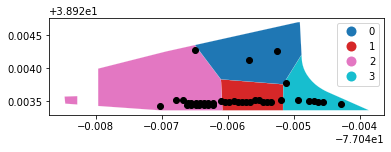

In [151]:
square_id = '2547'
poly_shapes_df = split_poly_into_parts(square_id, squares, addresses)
address_pts = address_pts = addresses[addresses.loc[:,'SQUARE']==square_id].copy()
fig, ax = plt.subplots()
poly_shapes_df.plot(column='group', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)
address_pts.plot(ax=ax, color='black')

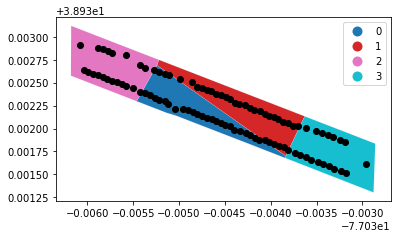

In [152]:
square_id = '2677'
poly_shapes_df = split_poly_into_parts(square_id, squares, addresses)
address_pts = address_pts = addresses[addresses.loc[:,'SQUARE']==square_id].copy()
fig, ax = plt.subplots()
poly_shapes_df.plot(column='group', categorical=True, legend=True, linewidth=0.1, edgecolor='white', ax=ax)
address_pts.plot(ax=ax, color='black')